In [2]:
suppressMessages(require(Rtsne))
suppressMessages(require(cellrangerRkit))
suppressMessages(require(ggplot2))
suppressMessages(require(data.table))
suppressMessages(require(gplots))
suppressMessages(require(matrixStats))
suppressMessages(require(RColorBrewer))
suppressMessages(require(RUVnormalize))
suppressMessages(require(Biostrings))

venn_matrix=function(inlist){
    #mk matrix
    out_matrix=matrix(NA,length(inlist),length(inlist))
    colnames(out_matrix)=names(inlist)
    rownames(out_matrix)=names(inlist)
    for(i in 2:length(inlist)){
        for(j in 1:(i-1)){
            out_matrix[i,j]=length(intersect(inlist[[i]],inlist[[j]]))
        }
    }
    diag(out_matrix)=sapply(inlist,length)
    return(out_matrix)
}

center_by_batch=function(inMatrix){
    inMatrix=scale(inMatrix,scale = F)
    batch_ids=as.numeric(stringi::stri_sub(rownames(inMatrix),-1, -1))
    unique_batch_ids=unique(batch_ids)
    for(i in 1:length(unique_batch_ids)){
        tagrow=batch_ids == unique_batch_ids[i]
        inMatrix[tagrow,]=scale(inMatrix[tagrow,],scale = F)
    }
    return(inMatrix)
}

In [3]:
load("testing_TPMandRUVscale.Rdata")
sample_list=c("C12pBMC","C12Rectum","C9pBMC","C9Rectum") #
valid_BCR_list=which(BCR_annoation$is_cell & BCR_annoation$high_confidence & BCR_annoation$productive)
valid_TCR_list=which(TCR_annoation$is_cell & TCR_annoation$high_confidence & TCR_annoation$productive)

In [33]:
recombined_BCR_list=which(is.na(BCR_annoation_w$v_gene)+is.na(BCR_annoation_w$d_gene)+is.na(BCR_annoation_w$j_gene)+is.na(BCR_annoation_w$c_gene)<3)
recombined_TCR_list=which(is.na(TCR_annoation_w$v_gene)+is.na(TCR_annoation_w$d_gene)+is.na(TCR_annoation_w$j_gene)+is.na(TCR_annoation_w$c_gene)<3)
BCR_annoation_w=BCR_annoation_w[recombined_BCR_list,]
TCR_annoation_w=TCR_annoation_w[recombined_TCR_list,]

In [14]:
#identify clonetype that's the same chain - v d j gene
tag_mat=TCR_annoation[valid_TCR_list,c("barcode","v_gene","d_gene","j_gene","c_gene","cdr3_nt","raw_clonotype_id")]
setDT(tag_mat)[, id := paste0("clonetype_",.GRP), by = .(v_gene,d_gene,j_gene,c_gene,cdr3_nt)]
sample_group=as.numeric(stringi::stri_sub(tag_mat$barcode,-1, -1))
expaned_clone=which(table(tag_mat$id)>1)

plot_table=list()
for(i in 1:max(sample_group)){
    tag=sample_group==i
    tag_id_tbl=table(tag_mat$id[tag])
    plot_table[[i]]=data.frame(clone_id=names(tag_id_tbl),
                               count=as.vector(tag_id_tbl),
                               freq=as.vector(tag_id_tbl)/sum(tag_id_tbl),
                               groups=sample_list[i]) 
}
clonetype_stat=do.call(rbind,plot_table)
clonetype_stat=clonetype_stat[order(clonetype_stat$freq,decreasing = T),]

plot_table=list()
for(i in 1:max(sample_group)){
    tag=clonetype_stat$groups==sample_list[i]
    tag_clonetype_stat=clonetype_stat[tag,]
    tag_freq_tbl=table(tag_clonetype_stat$freq)
    tag_count_tbl=table(tag_clonetype_stat$count)
    plot_table[[i]]=data.frame(groups=sample_list[i],
                               expansion_level_freq=as.numeric(names(tag_freq_tbl)),
                               expansion_level_count=as.numeric(names(tag_count_tbl)),
                               clone_count=as.vector(tag_count_tbl)) 
}
clonetype_expansion_count=do.call(rbind,plot_table)


In [1]:
ggplot(clonetype_expansion_count, aes(x=expansion_level_count,y=clone_count)) +
    geom_bar(stat="identity") +
    theme_minimal() + theme(axis.text.x = element_text(angle = 60, hjust = 1)) +
    labs(x = "expansion_level", y= "clone_count") +
    facet_wrap(~groups, nrow = 2, scales = "free")

ERROR: Error in ggplot(clonetype_expansion_count, aes(x = reorder(expansion_level_count, : could not find function "ggplot"


In [105]:
#shared clone
which(duplicated(clonetype_stat[,c("clone_id","groups")]))

integer(0)

In [109]:
clonetype_stat[1:5,]

,clone_id,count,freq,groups
1310,clonetype_610,51,0.03233989,C12Rectum
1308,clonetype_608,39,0.02473050,C12Rectum
1718,clonetype_1693,3,0.02362205,C9pBMC
1309,clonetype_609,35,0.02219404,C12Rectum
1704,clonetype_1679,2,0.01574803,C9pBMC


In [110]:
tag_mat[which(tag_mat$id=="clonetype_610"),]

barcode,v_gene,d_gene,j_gene,c_gene,cdr3_nt,raw_clonotype_id,id
AAACGGGAGCTGCCCA-2,TRBV19,TRBD2,TRBJ2-1,TRBC2,TGTGCCAGTAGAGCGACTAGCGGGAGTTTCTATGAGCAGTTCTTC,clonotype1,clonetype_610
AAGACCTAGATCCCAT-2,TRBV19,TRBD2,TRBJ2-1,TRBC2,TGTGCCAGTAGAGCGACTAGCGGGAGTTTCTATGAGCAGTTCTTC,clonotype135,clonetype_610
AAGGCAGCATCCGTGG-2,TRBV19,TRBD2,TRBJ2-1,TRBC2,TGTGCCAGTAGAGCGACTAGCGGGAGTTTCTATGAGCAGTTCTTC,clonotype2,clonetype_610
ACCTTTAGTATGAATG-2,TRBV19,TRBD2,TRBJ2-1,TRBC2,TGTGCCAGTAGAGCGACTAGCGGGAGTTTCTATGAGCAGTTCTTC,clonotype1,clonetype_610
ACGCAGCGTCCGAGTC-2,TRBV19,TRBD2,TRBJ2-1,TRBC2,TGTGCCAGTAGAGCGACTAGCGGGAGTTTCTATGAGCAGTTCTTC,clonotype4,clonetype_610
ACGTCAATCTGGCGAC-2,TRBV19,TRBD2,TRBJ2-1,TRBC2,TGTGCCAGTAGAGCGACTAGCGGGAGTTTCTATGAGCAGTTCTTC,clonotype8,clonetype_610
ACTTTCAAGCGTGTCC-2,TRBV19,TRBD2,TRBJ2-1,TRBC2,TGTGCCAGTAGAGCGACTAGCGGGAGTTTCTATGAGCAGTTCTTC,clonotype1,clonetype_610
AGAGTGGGTTCAGCGC-2,TRBV19,TRBD2,TRBJ2-1,TRBC2,TGTGCCAGTAGAGCGACTAGCGGGAGTTTCTATGAGCAGTTCTTC,clonotype1,clonetype_610
AGCTCTCGTCTAAACC-2,TRBV19,TRBD2,TRBJ2-1,TRBC2,TGTGCCAGTAGAGCGACTAGCGGGAGTTTCTATGAGCAGTTCTTC,clonotype4,clonetype_610
AGGGAGTTCCGCATAA-2,TRBV19,TRBD2,TRBJ2-1,TRBC2,TGTGCCAGTAGAGCGACTAGCGGGAGTTTCTATGAGCAGTTCTTC,clonotype8,clonetype_610


In [9]:
#B cell
tag_mat=BCR_annoation[valid_TCR_list,c("barcode","v_gene","d_gene","j_gene","c_gene","cdr3_nt","raw_clonotype_id")]
setDT(tag_mat)[, id := paste0("clonetype_",.GRP), by = .(v_gene,d_gene,j_gene,c_gene,cdr3_nt)]
sample_group=as.numeric(stringi::stri_sub(tag_mat$barcode,-1, -1))
expaned_clone=which(table(tag_mat$id)>1)

plot_table=list()
for(i in 1:max(sample_group)){
    tag=sample_group==i
    tag_id_tbl=table(tag_mat$id[tag])
    plot_table[[i]]=data.frame(clone_id=names(tag_id_tbl),
                               count=as.vector(tag_id_tbl),
                               freq=round(as.vector(tag_id_tbl)/sum(tag_id_tbl),4)*100,
                               groups=sample_list[i]) 
}
clonetype_stat=do.call(rbind,plot_table)
clonetype_stat=clonetype_stat[order(clonetype_stat$freq,decreasing = T),]

plot_table=list()
for(i in 1:max(sample_group)){
    tag=clonetype_stat$groups==sample_list[i]
    tag_clonetype_stat=clonetype_stat[tag,]
    tag_freq_tbl=table(tag_clonetype_stat$freq)
    tag_count_tbl=table(tag_clonetype_stat$count)
    plot_table[[i]]=data.frame(groups=sample_list[i],
                               expansion_level_freq=as.numeric(names(tag_freq_tbl)),
                               expansion_level_count=as.numeric(names(tag_count_tbl)),
                               clone_count=as.vector(tag_count_tbl)) 
}
clonetype_expansion_count=do.call(rbind,plot_table)


In [4]:
table(stringi::stri_sub(BCR_annoation$barcode,-1, -1))


   1    2    3    4 
 400 2239  118 2650 

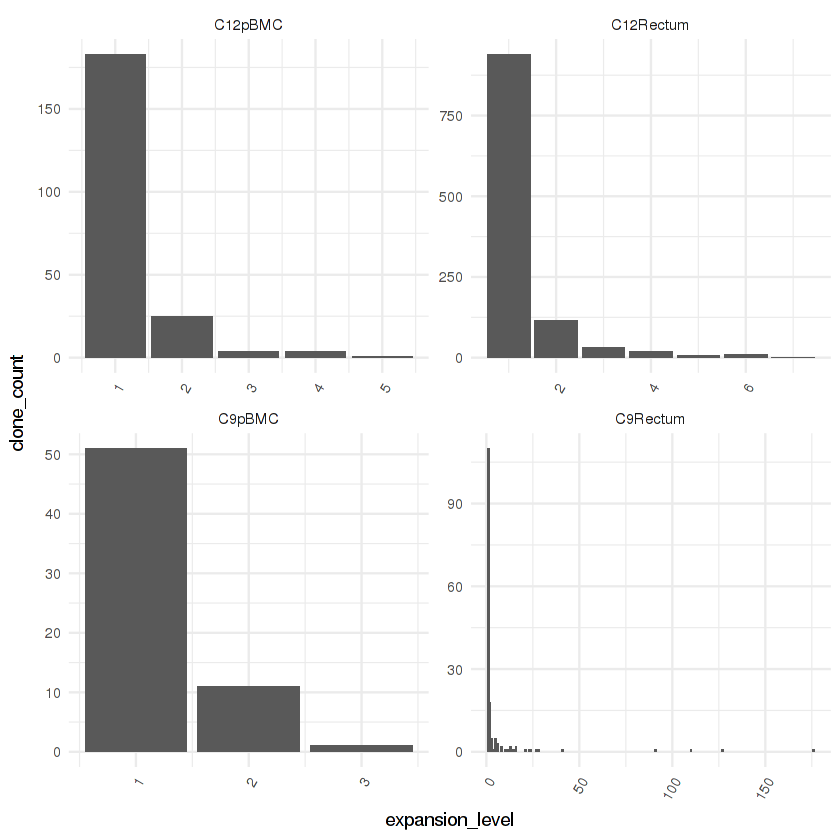

In [113]:
ggplot(clonetype_expansion_count, aes(x=expansion_level_count,y=clone_count)) +
    geom_bar(stat="identity") +
    theme_minimal() + theme(axis.text.x = element_text(angle = 60, hjust = 1)) +
    labs(x = "expansion_level", y= "clone_count") +
    facet_wrap(~groups, nrow = 2, scales = "free")

In [114]:
#shared clone
which(duplicated(clonetype_stat[,c("clone_id","groups")]))

integer(0)

# shared B/TCR

In [38]:
sample_list
BCR_annoation[BCR_annoation$barcode=="AAATGCCTCTGCCCTA-1",]
TCR_annoation_w[TCR_annoation_w$barcode=="AAATGCCTCTGCCCTA-1",]

[1] "C12pBMC"   "C12Rectum" "C9pBMC"    "C9Rectum"

barcode,is_cell,contig_id,high_confidence,length,chain,v_gene,d_gene,j_gene,c_gene,full_length,productive,cdr3,cdr3_nt,reads,umis,raw_clonotype_id,raw_consensus_id
AAATGCCTCTGCCCTA-1,TRUE,AAATGCCTCTGCCCTA-1_contig_1,TRUE,570,IGK,IGKV3-15,NA,IGKJ4,IGKC,TRUE,TRUE,CQQYNNWPPLTF,TGTCAGCAGTATAATAACTGGCCTCCGCTCACTTTC,807,25,clonotype6,clonotype6_consensus_1


,barcode,is_cell,contig_id,high_confidence,length,chain,v_gene,d_gene,j_gene,c_gene,full_length,productive,cdr3,cdr3_nt,reads,umis,raw_clonotype_id,raw_consensus_id
1234,AAATGCCTCTGCCCTA-1,FALSE,AAATGCCTCTGCCCTA-1_contig_1,TRUE,481,TRA,TRAV35,NA,TRAJ54,TRAC,TRUE,TRUE,CAGLVQGAQKLVF,TGTGCTGGGCTAGTTCAGGGAGCCCAGAAGCTGGTATTT,205,1,NA,NA
1235,AAATGCCTCTGCCCTA-1,FALSE,AAATGCCTCTGCCCTA-1_contig_2,TRUE,492,TRB,TRBV10-2,TRBD2,TRBJ2-3,TRBC2,TRUE,TRUE,CAIKTSGTDTQYF,TGCGCCATCAAGACTAGCGGCACAGATACGCAGTATTTT,495,2,NA,NA


In [39]:
BCR_annoation[BCR_annoation$barcode=="ACGTCAAGTAGATTAG-1",]
TCR_annoation_w[TCR_annoation_w$barcode=="ACGTCAAGTAGATTAG-1",]

,barcode,is_cell,contig_id,high_confidence,length,chain,v_gene,d_gene,j_gene,c_gene,full_length,productive,cdr3,cdr3_nt,reads,umis,raw_clonotype_id,raw_consensus_id
36,ACGTCAAGTAGATTAG-1,TRUE,ACGTCAAGTAGATTAG-1_contig_1,TRUE,333,IGH,IGHV3-23,NA,NA,IGHE,FALSE,NA,NA,NA,400,14,clonotype27,NA
37,ACGTCAAGTAGATTAG-1,TRUE,ACGTCAAGTAGATTAG-1_contig_2,TRUE,535,IGH,IGHV4-61,IGHD2-21,IGHJ6,IGHM,TRUE,TRUE,CARQLVVTAIPYGVDVW,TGTGCGAGGCAGCTAGTGGTGACTGCTATCCCTTACGGTGTGGACGTCTGG,146,8,clonotype27,clonotype27_consensus_1
38,ACGTCAAGTAGATTAG-1,TRUE,ACGTCAAGTAGATTAG-1_contig_3,TRUE,703,Multi,TRBV10-1,NA,NA,IGHM,FALSE,NA,NA,NA,108,6,clonotype27,NA
39,ACGTCAAGTAGATTAG-1,TRUE,ACGTCAAGTAGATTAG-1_contig_4,TRUE,674,IGK,IGKV2D-28,NA,IGKJ2,IGKC,TRUE,TRUE,CMQTLQTPQYTF,TGCATGCAAACTCTACAAACTCCTCAGTACACTTTT,7794,235,clonotype27,clonotype27_consensus_2
40,ACGTCAAGTAGATTAG-1,TRUE,ACGTCAAGTAGATTAG-1_contig_5,FALSE,657,IGK,IGKV1D-37,NA,IGKJ5,IGKC,TRUE,NA,NA,NA,1193,35,clonotype27,NA


,barcode,is_cell,contig_id,high_confidence,length,chain,v_gene,d_gene,j_gene,c_gene,full_length,productive,cdr3,cdr3_nt,reads,umis,raw_clonotype_id,raw_consensus_id
1325,ACGTCAAGTAGATTAG-1,FALSE,ACGTCAAGTAGATTAG-1_contig_1,TRUE,270,TRB,TRBV16,NA,NA,TRBC1,FALSE,NA,NA,NA,163,2,NA,NA


In [13]:
TCR_annoation[TCR_annoation$barcode=="AGGGATGAGAACAATC-1",]
BCR_annoation_w[BCR_annoation_w$barcode=="AGGGATGAGAACAATC-1",]

,barcode,is_cell,contig_id,high_confidence,length,chain,v_gene,d_gene,j_gene,c_gene,full_length,productive,cdr3,cdr3_nt,reads,umis,raw_clonotype_id,raw_consensus_id
172,AGGGATGAGAACAATC-1,TRUE,AGGGATGAGAACAATC-1_contig_1,TRUE,515,TRB,TRBV5-1,TRBD1,TRBJ2-1,TRBC2,TRUE,TRUE,CASSLVVPGKGGEQFF,TGCGCCAGCAGCTTGGTGGTCCCCGGCAAGGGGGGCGAGCAGTTCTTC,2044,9,clonotype82,clonotype82_consensus_1
173,AGGGATGAGAACAATC-1,TRUE,AGGGATGAGAACAATC-1_contig_2,TRUE,571,TRA,TRAV19,NA,TRAJ15,TRAC,TRUE,TRUE,CALSAPGQAGTALIF,TGTGCTCTGAGTGCCCCGGGGCAGGCAGGAACTGCTCTGATCTTT,1776,7,clonotype82,clonotype82_consensus_2
174,AGGGATGAGAACAATC-1,TRUE,AGGGATGAGAACAATC-1_contig_3,TRUE,289,Multi,IGKV1-16,NA,TRBJ2-6,NA,FALSE,NA,NA,NA,82,1,clonotype82,NA


,barcode,is_cell,contig_id,high_confidence,length,chain,v_gene,d_gene,j_gene,c_gene,full_length,productive,cdr3,cdr3_nt,reads,umis,raw_clonotype_id,raw_consensus_id
514,AGGGATGAGAACAATC-1,FALSE,AGGGATGAGAACAATC-1_contig_1,TRUE,256,IGL,IGLV1-44,NA,NA,NA,FALSE,NA,NA,NA,11,1,NA,NA


In [36]:
TCR_annoation[TCR_annoation$barcode=="TTGAACGCACGTAAGG-1",]
BCR_annoation_w[BCR_annoation_w$barcode=="TTGAACGCACGTAAGG-1",]

,barcode,is_cell,contig_id,high_confidence,length,chain,v_gene,d_gene,j_gene,c_gene,full_length,productive,cdr3,cdr3_nt,reads,umis,raw_clonotype_id,raw_consensus_id
1190,TTGAACGCACGTAAGG-1,TRUE,TTGAACGCACGTAAGG-1_contig_1,TRUE,518,TRB,TRBV5-6,TRBD1,TRBJ1-1,TRBC1,TRUE,TRUE,CASSIGWGGETEAFF,TGTGCCAGCAGCATAGGATGGGGGGGGGAAACTGAAGCTTTCTTT,1216,6,clonotype354,clonotype354_consensus_1
1191,TTGAACGCACGTAAGG-1,TRUE,TTGAACGCACGTAAGG-1_contig_2,TRUE,298,TRB,TRBV16,NA,NA,TRBC1,FALSE,NA,NA,NA,485,5,clonotype354,NA


,barcode,is_cell,contig_id,high_confidence,length,chain,v_gene,d_gene,j_gene,c_gene,full_length,productive,cdr3,cdr3_nt,reads,umis,raw_clonotype_id,raw_consensus_id
987,TTGAACGCACGTAAGG-1,FALSE,TTGAACGCACGTAAGG-1_contig_1,TRUE,350,IGK,IGKV1-33,NA,IGKJ2,NA,FALSE,NA,CQQSYSTPLYTF,TGTCAACAGAGTTACAGTACCCCTTTGTACACTTTT,25,1,NA,NA


In [37]:
BCR_annoation[which(BCR_annoation$barcode %in% TCR_annoation_w$barcode)[1:20],]

,barcode,is_cell,contig_id,high_confidence,length,chain,v_gene,d_gene,j_gene,c_gene,full_length,productive,cdr3,cdr3_nt,reads,umis,raw_clonotype_id,raw_consensus_id
1,AAATGCCTCTGCCCTA-1,TRUE,AAATGCCTCTGCCCTA-1_contig_1,TRUE,570,IGK,IGKV3-15,NA,IGKJ4,IGKC,TRUE,TRUE,CQQYNNWPPLTF,TGTCAGCAGTATAATAACTGGCCTCCGCTCACTTTC,807,25,clonotype6,clonotype6_consensus_1
2,AACCGCGAGAAACCGC-1,TRUE,AACCGCGAGAAACCGC-1_contig_1,TRUE,557,IGL,IGLV3-19,NA,IGLJ2,IGLC2,TRUE,TRUE,CNSRDSSGNHLKVVF,TGTAACTCCCGGGACAGCAGTGGTAACCATCTAAAGGTGGTATTC,149,8,clonotype7,clonotype7_consensus_1
3,AACCGCGAGAAACCGC-1,TRUE,AACCGCGAGAAACCGC-1_contig_2,TRUE,334,IGH,IGHV7-81,NA,NA,NA,FALSE,NA,NA,NA,48,3,clonotype7,NA
31,ACGGCCACACCTGGTG-1,TRUE,ACGGCCACACCTGGTG-1_contig_1,TRUE,567,IGK,IGKV2D-28,NA,IGKJ4,IGKC,TRUE,TRUE,CMQALQTPLTF,TGCATGCAAGCTCTACAAACTCCGCTCACTTTC,637,20,clonotype25,clonotype25_consensus_2
32,ACGGCCACACCTGGTG-1,TRUE,ACGGCCACACCTGGTG-1_contig_2,TRUE,549,IGH,IGHV4-31,IGHD4-17,IGHJ4,IGHM,TRUE,TRUE,CARADYGDYEGQGVYFDYW,TGTGCCCGTGCCGACTACGGTGACTACGAGGGGCAGGGGGTCTACTTTGACTACTGG,152,7,clonotype25,clonotype25_consensus_1
36,ACGTCAAGTAGATTAG-1,TRUE,ACGTCAAGTAGATTAG-1_contig_1,TRUE,333,IGH,IGHV3-23,NA,NA,IGHE,FALSE,NA,NA,NA,400,14,clonotype27,NA
37,ACGTCAAGTAGATTAG-1,TRUE,ACGTCAAGTAGATTAG-1_contig_2,TRUE,535,IGH,IGHV4-61,IGHD2-21,IGHJ6,IGHM,TRUE,TRUE,CARQLVVTAIPYGVDVW,TGTGCGAGGCAGCTAGTGGTGACTGCTATCCCTTACGGTGTGGACGTCTGG,146,8,clonotype27,clonotype27_consensus_1
38,ACGTCAAGTAGATTAG-1,TRUE,ACGTCAAGTAGATTAG-1_contig_3,TRUE,703,Multi,TRBV10-1,NA,NA,IGHM,FALSE,NA,NA,NA,108,6,clonotype27,NA
39,ACGTCAAGTAGATTAG-1,TRUE,ACGTCAAGTAGATTAG-1_contig_4,TRUE,674,IGK,IGKV2D-28,NA,IGKJ2,IGKC,TRUE,TRUE,CMQTLQTPQYTF,TGCATGCAAACTCTACAAACTCCTCAGTACACTTTT,7794,235,clonotype27,clonotype27_consensus_2
40,ACGTCAAGTAGATTAG-1,TRUE,ACGTCAAGTAGATTAG-1_contig_5,FALSE,657,IGK,IGKV1D-37,NA,IGKJ5,IGKC,TRUE,NA,NA,NA,1193,35,clonotype27,NA


In [8]:
length(unique(BCR_annoation$barcode[which(BCR_annoation$barcode %in% TCR_annoation$barcode)]))

[1] 38

In [10]:
length(unique(BCR_annoation$barcode[which(BCR_annoation$barcode %in% TCR_annoation_w$barcode)]))
length(unique(TCR_annoation$barcode[which(TCR_annoation$barcode %in% BCR_annoation_w$barcode)]))

[1] 30

[1] 5

In [7]:
unique(stringi::stri_sub(TCR_annoation_w$barcode,-1, -1))
unique(stringi::stri_sub(TCR_annoation$barcode,-1, -1))

[1] "1" "2" "3" "4"

[1] "1" "2" "3" "4"

In [34]:
pdf("cells label overlaping between TCR_BCR samples_with recombination signature.pdf",width=7,height=7)
venn(list(failed_TCR=unique(TCR_annoation_w$barcode),
          TCR=unique(TCR_annoation$barcode),
          BCR=unique(BCR_annoation$barcode),
          failed_BCR=unique(BCR_annoation_w$barcode)
         ),small=0.5)
title(main="all")
dev.off()

png 
  2

In [5]:
ls()

[1] "BCR_annoation"    "BCR_annoation_w"  "cell_assignment"  "center_by_batch" 
 [5] "ExpressionMat"    "ExpressionNormed" "pca_allcell"      "rtsne_allcell"   
 [9] "sample_list"      "TCR_annoation"    "TCR_annoation_w"  "valid_BCR_list"  
[13] "valid_TCR_list"   "venn_matrix"

In [6]:
table(cell_assignment)

cell_assignment
        B cell     dual-label failed BCR/TCR         T cell        unknown 
          1886             38            355           1545            917 